In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib
from bnpgmm_runjingdev import utils_lib

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Load data

In [3]:
# load iris data
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

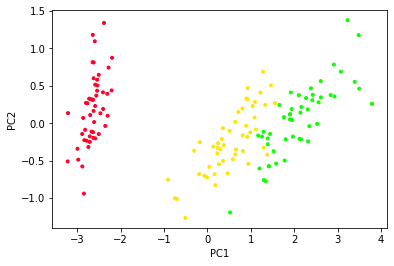

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# File paths

In [5]:
out_folder = '../fits/'
out_filename = 'iris_fit'

In [6]:
alpha0 = 6.0

In [7]:
# class with method to load all files from a particular perturbation
gmm_result_loader = result_loading_utils.FunctionalRefitsLoader(alpha0, 
                                 out_folder, 
                                 out_filename)

loading initial fit from:  ../fits/iris_fit_alpha6.0.npz
loading lr derivatives from:  ../fits/iris_fit_alpha6.0_lrderivatives.npz


### Some meta data and model parameters

In [8]:
vb_init_free = gmm_result_loader.vb_init_free
vb_params_paragami = gmm_result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [9]:
# gauss-hermite parameters
gh_deg = int(gmm_result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
assert alpha0 == gmm_result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Plot initial fit

In [10]:
ez_init = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                                            vb_init_dict,
                                            gh_loc,
                                            gh_weights,
                                            use_bnp_prior = True)


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], 
                            pc_iris_obs[:, 1],
                            bnp_clusters, 
                            colors1, fig, 
                            centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                            cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


Text(0, 0.5, 'PC2')

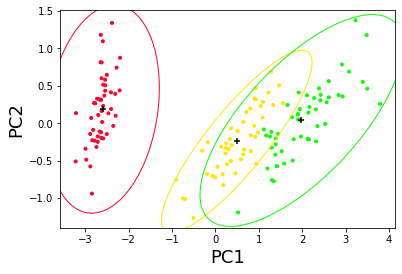

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_init_dict, ez_init, fig)

fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Function to compute centroids

In [13]:
def get_centroids(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    centroids = vb_params_dict['cluster_params']['centroids']
    
    centroids_pc = pca_fit.transform(centroids)
    
    return centroids_pc

# Function to make trace plot of centroids

In [14]:
def plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec): 
    
    # get arrays of mixture weights
    centroids_refit_array = result_loading_utils.get_post_stat_vec(get_centroids, vb_refit_list)
    centroids_lr_array = result_loading_utils.get_post_stat_vec(get_centroids, lr_list)
    
    fig, axarr = plt.subplots(2, 4, figsize = (15, 6))
    result_loading_utils.plot_centroids(centroids_refit_array, centroids_lr_array, axarr)
    fig.tight_layout()
    
    return centroids_refit_array, centroids_lr_array

# Function to plot results

In [15]:
def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
    
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        gmm_result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    #################
    # plot centroids
    #################
    return plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec)

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Optim time at epsilon = 1: 1.522secs
Derivative time: 0.016secs


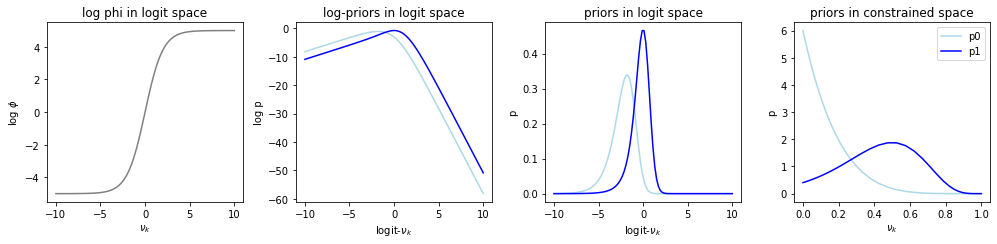

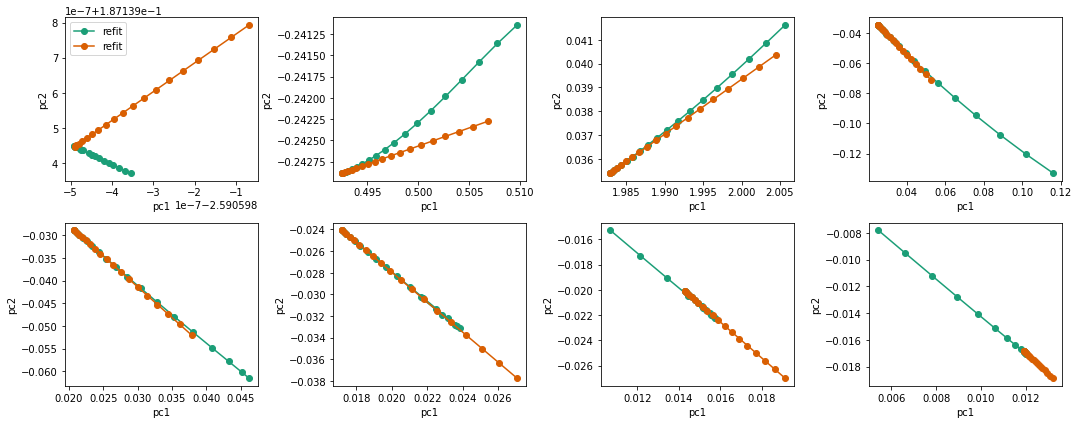

In [16]:
delta = 5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

foo = plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 1.582secs
Derivative time: 0.016secs


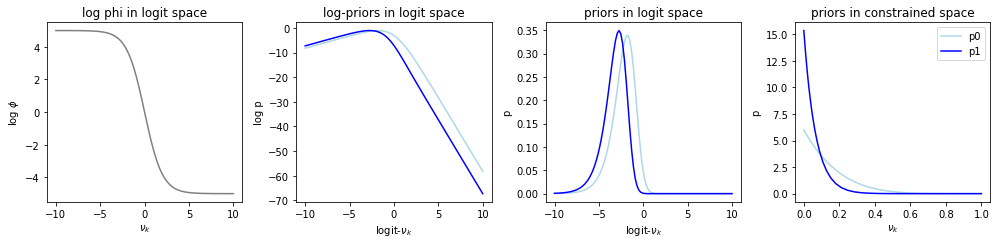

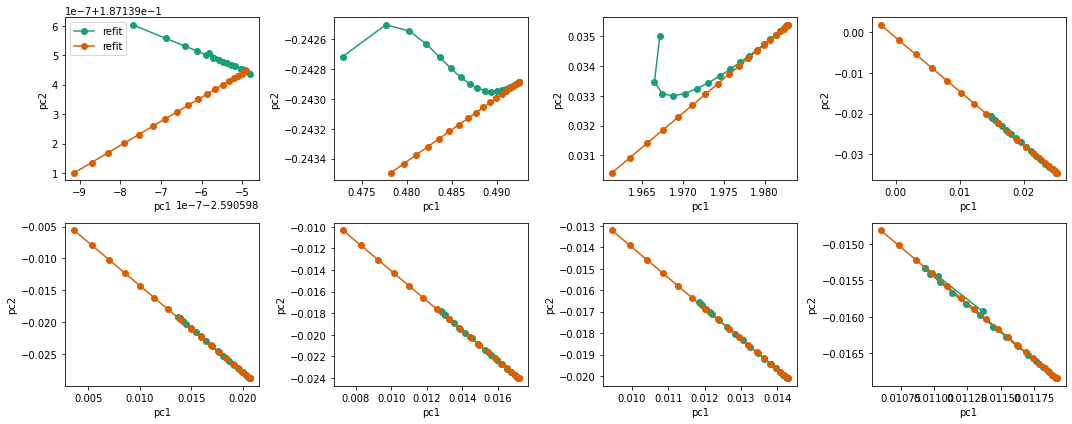

In [17]:
delta = -5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);

# Alpha-type perturbations

Optim time at epsilon = 1: 1.501secs
Derivative time: 0.016secs


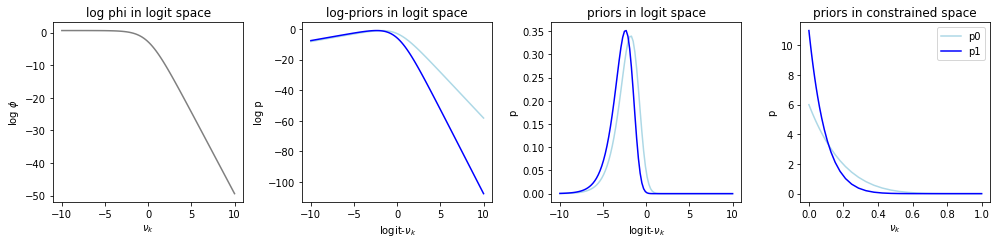

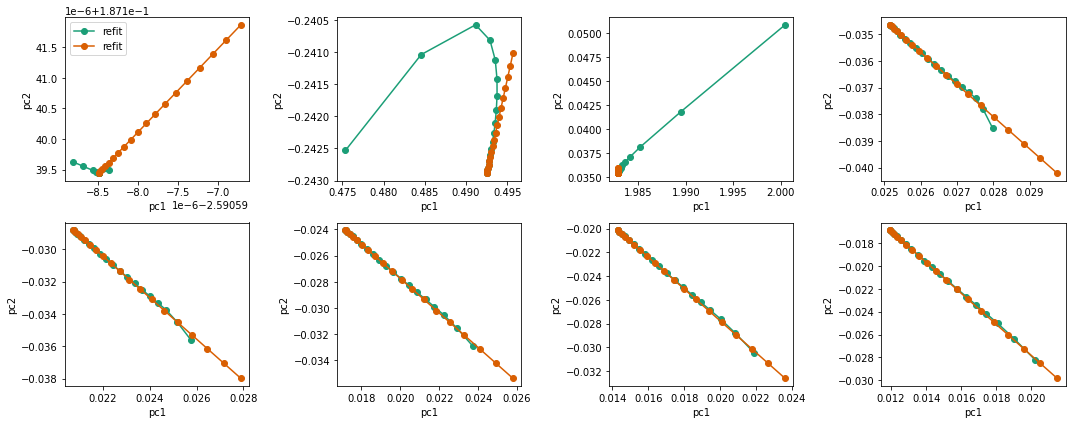

In [18]:
delta = 1
perturbation = 'alpha_pert_pos'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);

Optim time at epsilon = 1: 1.524secs
Derivative time: 0.016secs


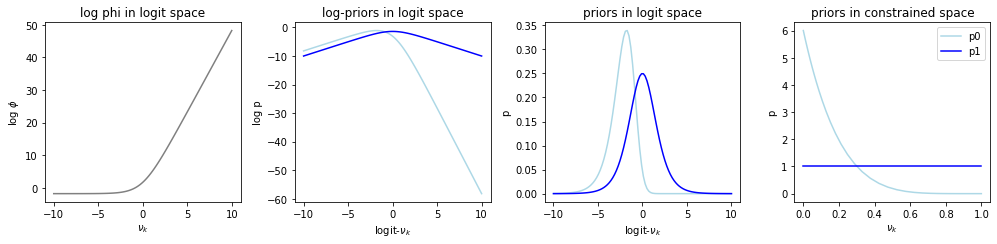

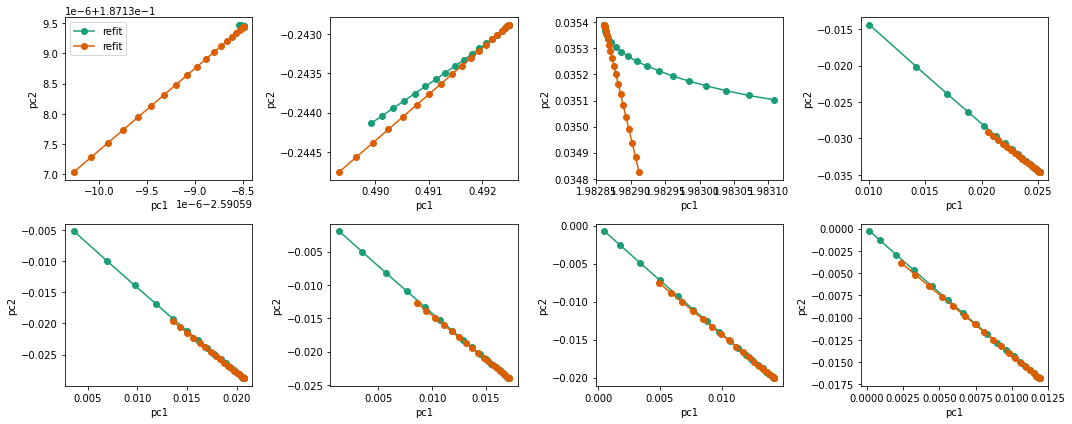

In [19]:
delta = 1
perturbation = 'alpha_pert_neg'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);

# Gaussian bumps

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.362176e-04
  warnings.warn(


Optim time at epsilon = 1: 1.247secs
Derivative time: 0.016secs


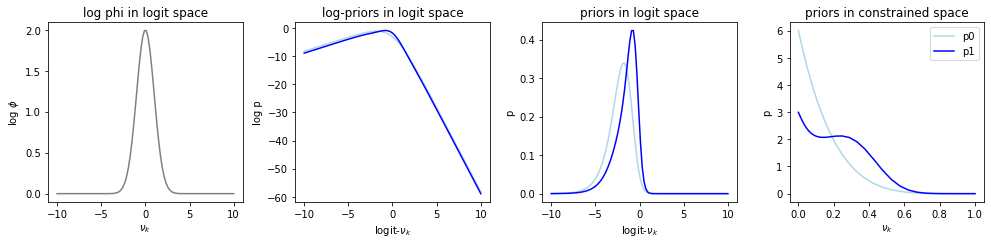

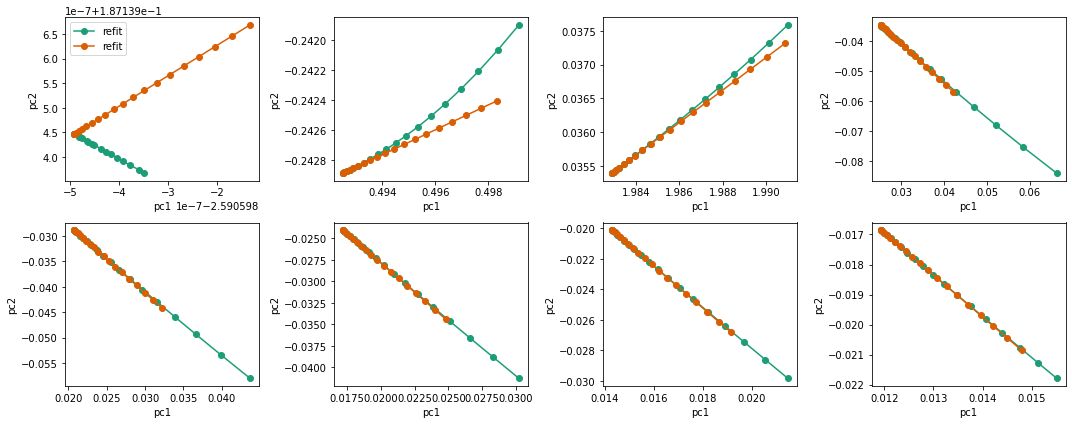

In [20]:
delta = 2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.070934e-06
  warnings.warn(


Optim time at epsilon = 1: 1.462secs
Derivative time: 0.016secs


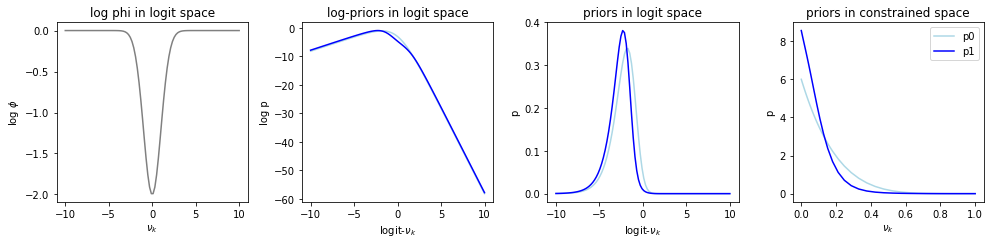

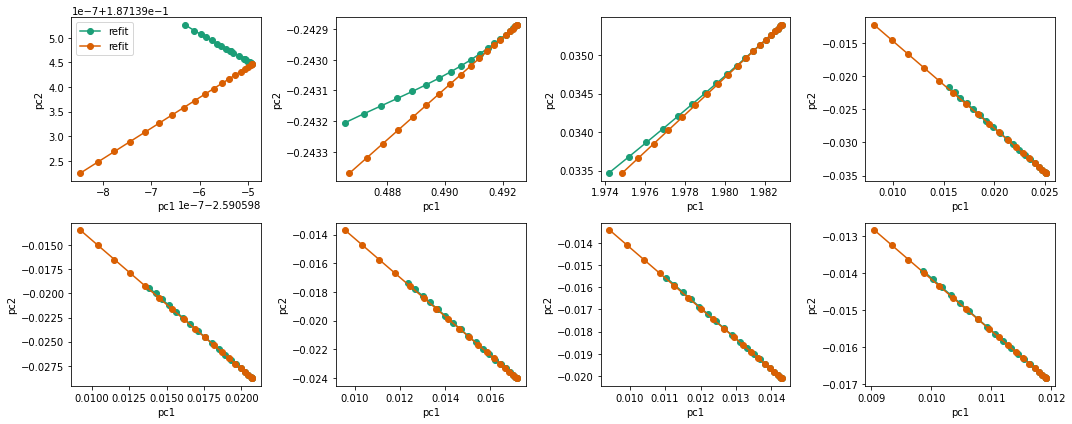

In [21]:
delta = -2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.091173e-05
  warnings.warn(


Optim time at epsilon = 1: 1.437secs
Derivative time: 0.015secs


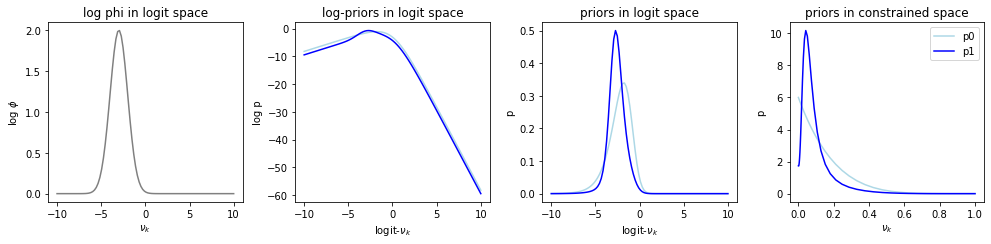

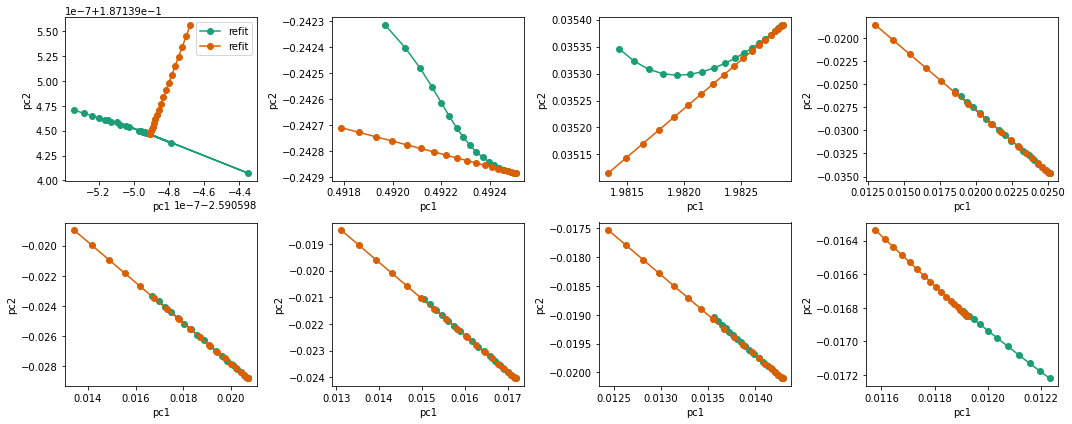

In [22]:
delta = 2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.327195e-07
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.136652e-07
  warnings.warn(


Optim time at epsilon = 1: 1.266secs
Derivative time: 0.015secs


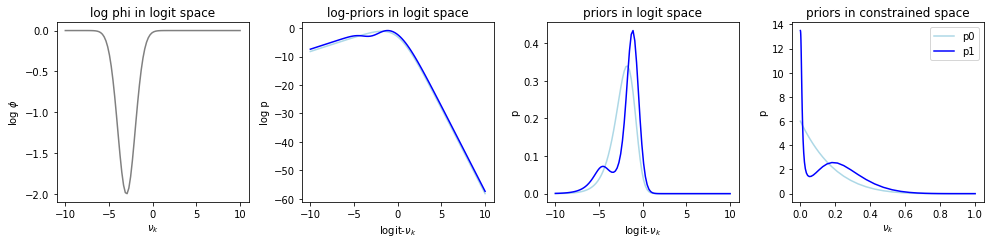

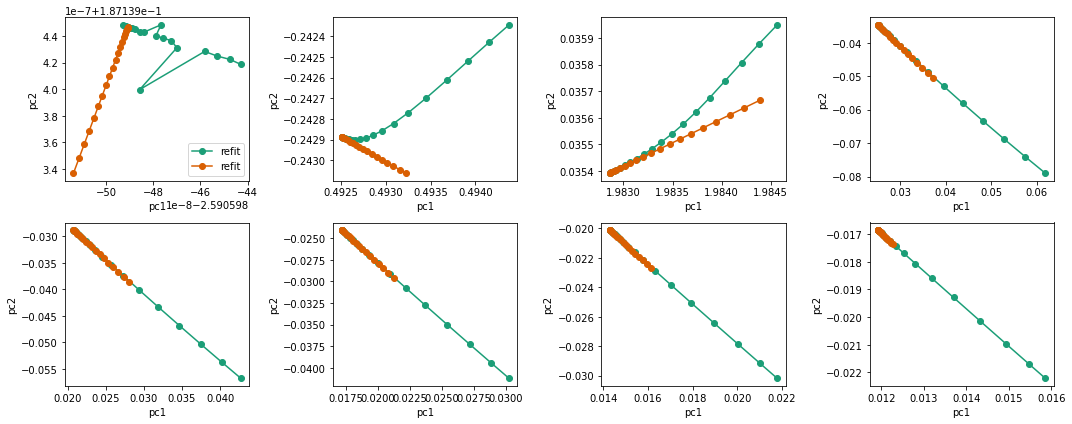

In [23]:
delta = -2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1]);